In [1]:
## file twi_neo_repeat3_iz_np1_v2.2_10yrs.db available at: https://s3df.slac.stanford.edu/groups/rubin/static/sim-data/defunct_sims_featureScheduler_runs2.2/twilight_neo/
##  DO NOT ADD TO THE REPO!!!!


In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import sqlite3
from scipy.stats import binned_statistic
import rubin_sim.maf as maf

In [3]:
# grab this out of MAF so I can try to add a rasterize

class LambertSkyMap(maf.BasePlotter):
    """
    Use basemap and contour to make a Lambertian projection.
    Note that the plotDict can include a 'basemap' key with a dictionary of
    arbitrary kwargs to use with the call to Basemap.
    """

    def __init__(self):
        self.plotType = "SkyMap"
        self.objectPlotter = False
        self.defaultPlotDict = {}
        self.defaultPlotDict.update(baseDefaultPlotDict)
        self.defaultPlotDict.update(
            {
                "basemap": {
                    "projection": "nplaea",
                    "boundinglat": 1,
                    "lon_0": 180,
                    "resolution": None,
                    "celestial": False,
                    "round": False,
                },
                "levels": 200,
                "cbarFormat": "%i",
                "norm": None,
            }
        )

    def __call__(self, metricValueIn, slicer, userPlotDict, fignum=None):

        if "ra" not in slicer.slicePoints or "dec" not in slicer.slicePoints:
            errMessage = (
                'SpatialSlicer must contain "ra" and "dec" in slicePoints metadata.'
            )
            errMessage += " SlicePoints only contains keys %s." % (
                slicer.slicePoints.keys()
            )
            raise ValueError(errMessage)

        plotDict = {}
        plotDict.update(self.defaultPlotDict)
        plotDict.update(userPlotDict)

        metricValue = applyZPNorm(metricValueIn, plotDict)
        clims = setColorLims(metricValue, plotDict)
        # Calculate the levels to use for the contour
        if np.size(plotDict["levels"]) > 1:
            levels = plotDict["levels"]
        else:
            step = (clims[1] - clims[0]) / plotDict["levels"]
            levels = np.arange(clims[0], clims[1] + step, step)

        fig = plt.figure(fignum, figsize=plotDict["figsize"])
        ax = fig.add_subplot(plotDict["subplot"])

        x, y = project_lambert(slicer.slicePoints["ra"], slicer.slicePoints["dec"])
        # Contour the plot first to remove any anti-aliasing artifacts.  Doesn't seem to work though. See:
        # http: //stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib\
        # -filled-contour-plot-to-pdf-or-eps
        # tmpContour = m.contour(np.degrees(slicer.slicePoints['ra']),
        #                        np.degrees(slicer.slicePoints['dec']),
        #                        metricValue.filled(np.min(clims)-1), levels, tri=True,
        #                        cmap=plotDict['cmap'], ax=ax, latlon=True,
        #                        lw=1)

        # Set masked values to be below the lowest contour level.
        if plotDict["norm"] == "log":
            z_val = metricValue.filled(np.min(clims) - 0.9)
            norm = colors.LogNorm(vmin=z_val.min(), vmax=z_val.max())
        else:
            norm = plotDict["norm"]
        tcf = ax.tricontourf(
            x,
            y,
            metricValue.filled(np.min(clims) - 0.9),
            levels,
            cmap=plotDict["cmap"],
            norm=norm, rasterize=True
        )

        ax = draw_grat(ax)

        ax.set_xticks([])
        ax.set_yticks([])
        alt_limit = 10.0
        x, y = project_lambert(0, np.radians(alt_limit))
        max_val = np.max(np.abs([x, y]))
        ax.set_xlim([-max_val, max_val])
        ax.set_ylim([-max_val, max_val])

        # Try to fix the ugly pdf contour problem
        for c in tcf.collections:
            c.set_edgecolor("face")

        cb = plt.colorbar(tcf, format=plotDict["cbarFormat"])
        cb.set_label(plotDict["xlabel"])
        if plotDict["labelsize"] is not None:
            cb.ax.tick_params(labelsize=plotDict["labelsize"])
        # Pop in an extra line to raise the title a bit
        ax.set_title(plotDict["title"] + "\n ")
        # If outputing to PDF, this fixes the colorbar white stripes
        if plotDict["cbar_edge"]:
            cb.solids.set_edgecolor("face")
        return fig.number

In [4]:
# Let's make a plot looking at how the twilight NEO observations are distributed

bundleList = []

nside=64
metric = maf.CountMetric(col='night')
sql = 'night < 366 and visitExposureTime < 20'

slicer = maf.HealpixSlicer(
        nside=nside,
        latCol='altitude',
        lonCol='azimuth',
        useCache=False)
plotFuncs = [maf.LambertSkyMap()]
plotDict = {"norm": "log", 'title': 'Twilight NEO Observations',
           'xlabel': 'N Observations'}

bundle = maf.MetricBundle(
            metric,
            slicer,
            sql,
            plotFuncs=plotFuncs,
            plotDict=plotDict,
        )
bundleList.append(bundle)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


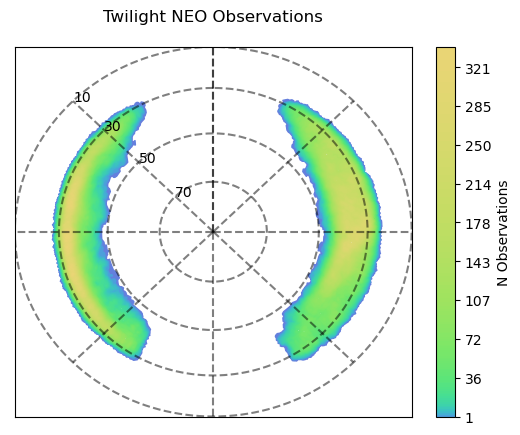

In [5]:
bg = maf.MetricBundleGroup([bundle], 'twi_neo_repeat3_iz_np1_v2.2_10yrs.db', 'temp', None)
bg.runAll()
bg.plotAll(closefigs=False)

oneweb 0.01373660824602918
slv1 0.005185290160562576
slv2 0.039243625446929165


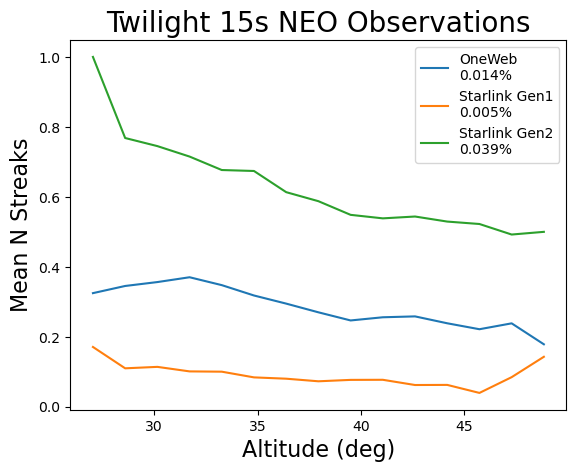

In [8]:
tags = ['oneweb', 'slv1', 'slv2']
pix_width = 50
pixscale = 0.2
n_pix = 2.9e9

labels = {'slv1': 'Starlink Gen1',
          'slv2': 'Starlink Gen2',
          'oneweb': 'OneWeb'}

con = sqlite3.connect('twi_neo_repeat3_iz_np1_v2.2_10yrs.db')

for tag in tags:
    orig = pd.read_sql('select * from observations where night < 366', con)
    data = np.load('twi_neo_repeat3_iz_np1_v2.2_10yrs%s.npz' % tag)['obs_array'].copy()
    indx = np.in1d(orig['observationId'].values, data['observationId'])
    
    orig = orig.iloc[np.where(indx == True)[0]]
    
    twi_indx = np.where(orig['visitExposureTime'] < 20)[0]
    reg_indx = np.where(orig['visitExposureTime'] >= 20)[0]

    
    pix_lost = data['streak_len_deg'][twi_indx].mean() * 3600/pixscale * pix_width  # pix per image
    pix_lost_percent = pix_lost/n_pix*100
    
    print(tag, pix_lost_percent)
    
    mean_n_s, alts, bd = binned_statistic(orig['altitude'].values[twi_indx], data['n_streaks'][twi_indx], bins=15)
    plt.plot(alts[1:], mean_n_s, label=labels[tag]+'\n%.3f%%' % pix_lost_percent)

plt.legend()
plt.xlabel('Altitude (deg)', fontsize=16)
plt.ylabel('Mean N Streaks', fontsize=16)
plt.title('Twilight 15s NEO Observations', fontsize=20)
plt.savefig('twilight_curves.pdf')
con.close()

In [7]:
# sanity check, one 3.5 degree streak wipes out what % of pixels?
3.5*3600/.2*50/2.9e9*100

0.10862068965517241